# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
!pip install --upgrade bottleneck --user

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [4]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [5]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [6]:
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).astype('int64') // 10**9

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: 'ph' refers to the prediction horizon, which is how far into the future we want to predict. 'mu' is the weighting factor that determines how much influence past data points have on the model's predictions

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.** -- this indicates we will set 'ph' to 5 because out timesteps are in 1 minute increments.

In [8]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: 0.9^(5000-1), which is really small due to exponential decay.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [9]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    
    #weights = np.ones(ns)*mu
    #for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
    #    weights[k] = ?
    #weights = np.flip(weights, 0)
        
    weights = np.power(mu, np.arange(ns))
    
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp.coef_[0][0]
    q_tmp = lm_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1].item() + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

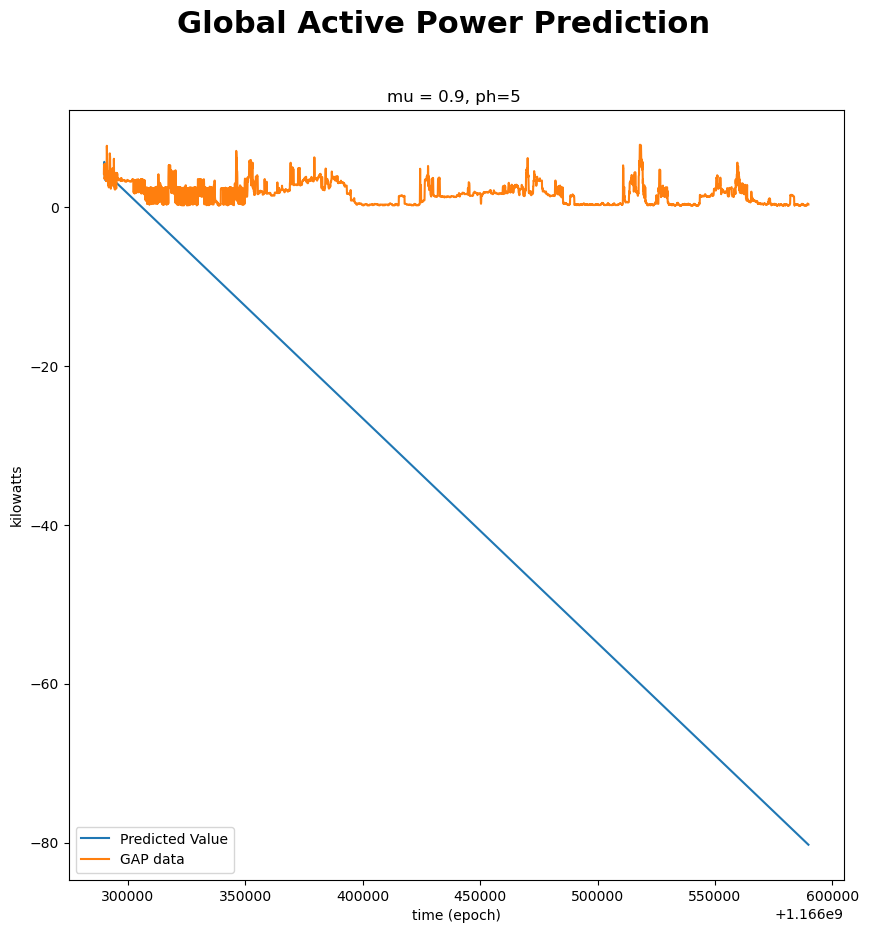

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

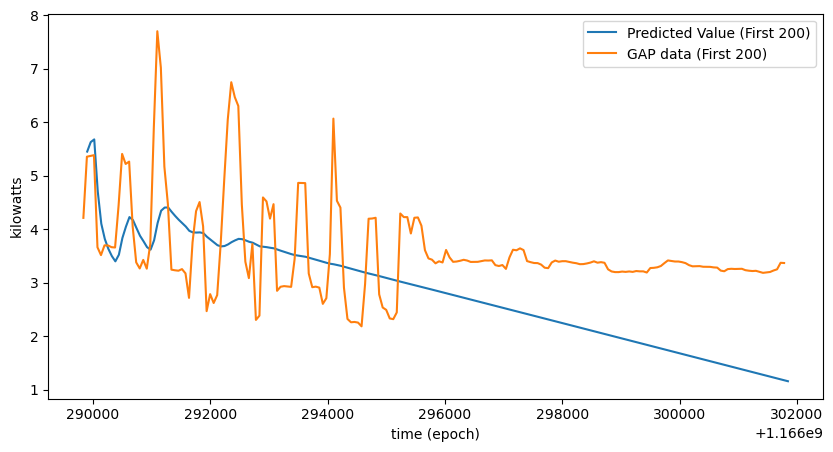

In [11]:
#Plot first 200 data points/predictions
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value (First 200)')
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data (First 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

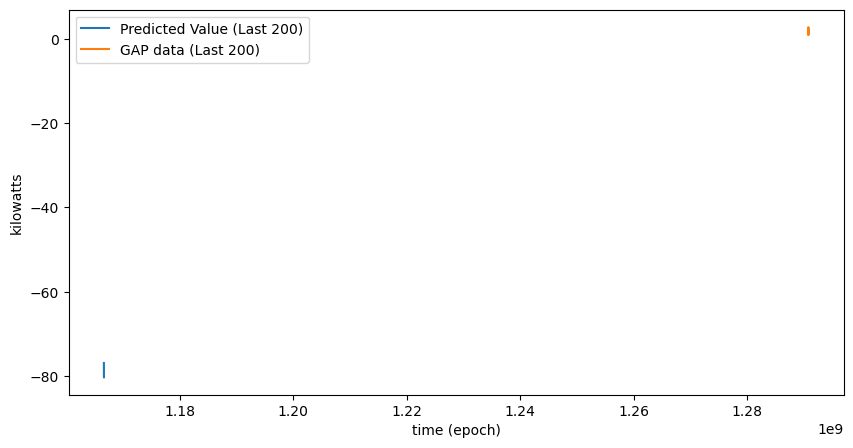

In [12]:
#Plot last 200 data points/predictions
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value (Last 200)')
plt.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data (Last 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

In [13]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 2141.1332571412436


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The graphs show a deviation from the predicted and actual values. In the beginning, the prediction is close but as the predictions go on, it deviates more and more. In the end, the predictions aren't even close to the actual values. The MSE of 2141.13 means that the average squared difference between the predicted and actual values is high, we aren't accurately capturing the patterns in the data.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [14]:
def perform_linear_regression(mu_value, n_s, ts, ys, ph):
    tp_pred = np.zeros(n_s-1)
    yp_pred = np.zeros(n_s-1)

    for i in range(2, n_s+1):
        ts_tmp = ts.iloc[:i]
        ys_tmp = ys.iloc[:i]
        ns = len(ys_tmp)

        weights = np.power(mu_value, np.arange(ns))

        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

        m_tmp = lm_tmp.coef_[0][0]
        q_tmp = lm_tmp.intercept_[0]

        tp = ts.iloc[i-1].item() + ph
        yp = m_tmp * tp + q_tmp

        tp_pred[i-2] = tp    
        yp_pred[i-2] = yp
    
    return tp_pred, yp_pred

In [15]:
mu = 1
tp_pred_1, yp_pred_1 = perform_linear_regression(mu, n_s, ts, ys, ph)

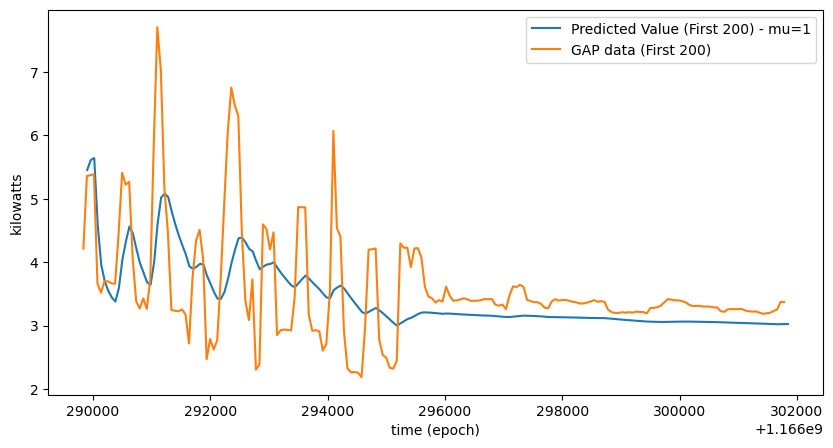

In [16]:
#Plot first 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 5))
plt.plot(tp_pred_1[:200], yp_pred_1[:200], label='Predicted Value (First 200) - mu=1')
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data (First 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

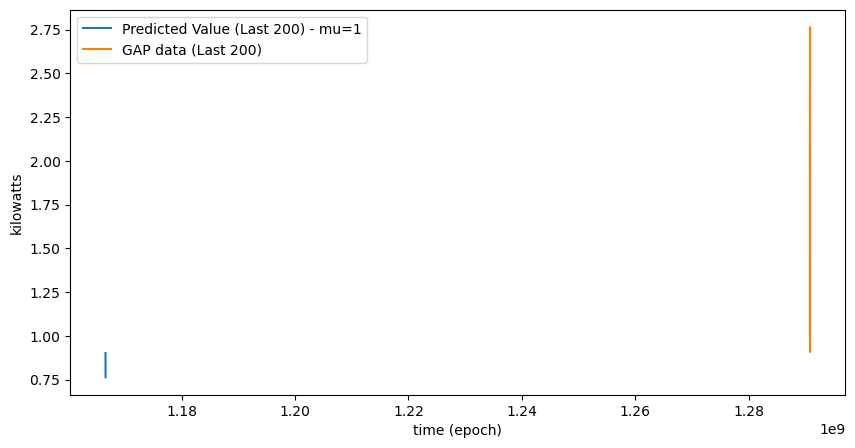

In [17]:
#Plot last 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 5))
plt.plot(tp_pred_1[-200:], yp_pred_1[-200:], label='Predicted Value (Last 200) - mu=1')
plt.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data (Last 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

In [18]:
#Calculate MSE of predictions for mu = 1
mse_1 = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred_1)
print("MSE for mu=1 is", mse_1)

MSE for mu=1 is 1.4172641534415351


In [19]:
mu = 0.01
tp_pred_001, yp_pred_001 = perform_linear_regression(mu, n_s, ts, ys, ph)

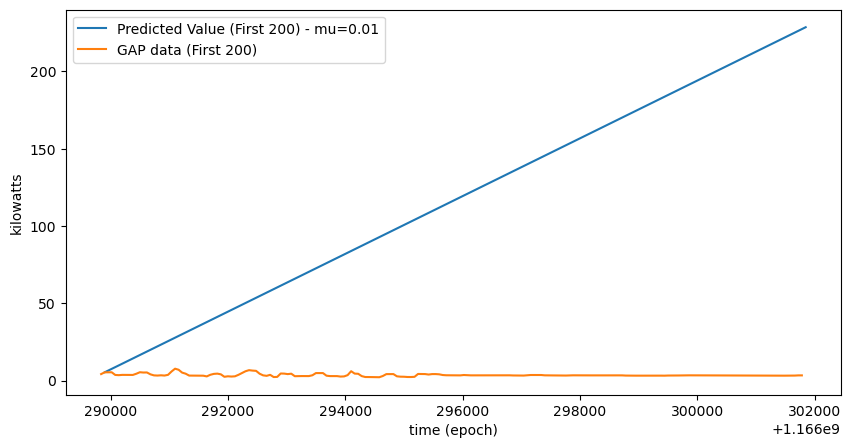

In [20]:
#Plot first 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 5))
plt.plot(tp_pred_001[:200], yp_pred_001[:200], label='Predicted Value (First 200) - mu=0.01')
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data (First 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

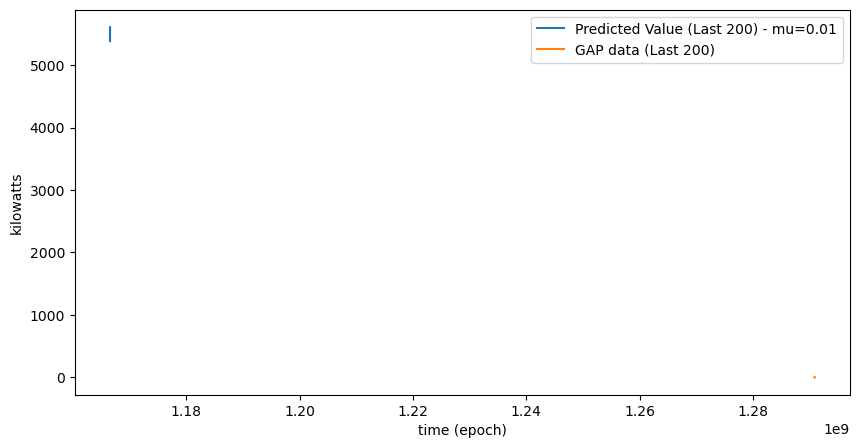

In [21]:
#Plot last 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 5))
plt.plot(tp_pred_001[-200:], yp_pred_001[-200:], label='Predicted Value (Last 200) - mu=0.01')
plt.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data (Last 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

In [22]:
#Calculate MSE of predictions for mu = 0.01
mse_001 = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred_001)
print("MSE for mu=0.01 is", mse_001)

MSE for mu=0.01 is 10496756.10373284


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model performed much better than the mu= 0.9, with a substantially better MSE of 1.42, the charts show much better predictions for the first 200 predictions compared to actual. Late predictions were still off.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model performed much more poor than the mu = 0.9, there was a large deviation the predicted and actual values, the MSE for mu = 0.01 was 10496756.10

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The best model was mu = 1, based on it's better predictions vs actual and lower MSE. For this dataset, treating all the past data equally (without decay in the weight) is more effective.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: To improve our model, we could use more features, introduce feature engineering, include weather data/time of day indicators, etc. We could also use different 'ph' to see if different time horizons make a difference. Alternatively, we could try out different models.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [46]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df['unix'],
    'Voltage': df['Voltage']
})

ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5
mu = 0.9
#mu= 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [47]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)

    weights = np.power(mu, np.arange(ns))

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = lm_tmp.coef_[0]
    q_tmp = lm_tmp.intercept_

    tp = ts.iloc[i-1] + ph
    yp = np.dot(m_tmp, tp) + q_tmp

    tp_pred[i-2] = ts.iloc[i-1, 0] + ph
    yp_pred[i-2] = yp

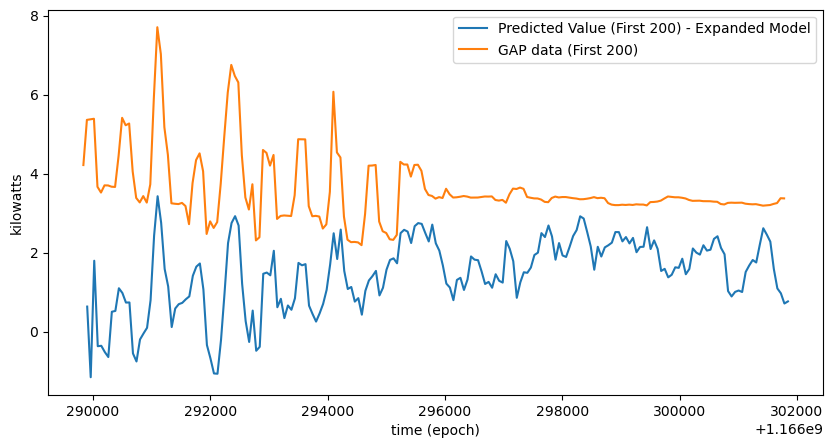

In [48]:
#Plot first 200 data points/predictions for the expanded dataset
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value (First 200) - Expanded Model')
plt.plot(ts['unix'].iloc[:200], ys.iloc[:200, 0], label='GAP data (First 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

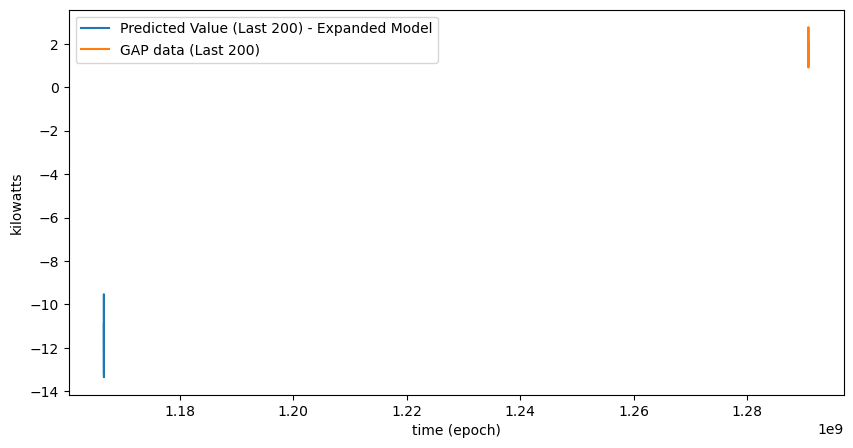

In [49]:
#Plot last 200 data points/predictions for the expanded data
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value (Last 200) - Expanded Model')
plt.plot(ts['unix'].iloc[-200:], ys.iloc[-200:, 0], label='GAP data (Last 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

In [50]:
#Calculate MSE of predictions for the expanded data
mse_expanded = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred)
print("MSE for the expanded dataset is", mse_expanded)

MSE for the expanded dataset is 67.27413530558275


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model performed better than the mu = 0.9 base model, this suggests that voltage is a relevant predictor for 'Global Active Power' and it's inclusion captures some of the variability in the data.
However, when comparing the mu = 1 base model, to this with mu = 1, the base model has a lower MSE and the predicted and actual values track better. This indicates that without an exponential decay, excluding voltage is better -- more testing is needed, but it appears that voltage may just be useful 'noise'.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I like the idea of using a moving average as the response variable. I think this method will assist in capturing the variability because averaging the 'Global Active Power' over a set number of previous time steps and using this moving average as a new response variable can be a powerful localization (it can especially help with large fluctuations in the data) for the prediction.

In [61]:
#create your alternative training data here
window_size = 5
df['gap_moving_avg'] = df['Global_active_power'].rolling(window=window_size).mean().shift(-window_size+1)

ys = pd.DataFrame(df['gap_moving_avg'].iloc[window_size-1:-window_size+1])


ph = 5 #5 minutes
ph_index = 5
mu = 0.9
#mu =  1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [62]:
#re-run the prediction code here
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)

    weights = np.power(mu, np.arange(ns))

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = lm_tmp.coef_[0]
    q_tmp = lm_tmp.intercept_

    tp = ts.iloc[i-1, 0] + ph
    yp = np.dot(m_tmp, ts.iloc[i-1]) + q_tmp

    tp_pred[i-2] = ts.iloc[i-1, 0] + ph
    yp_pred[i-2] = yp


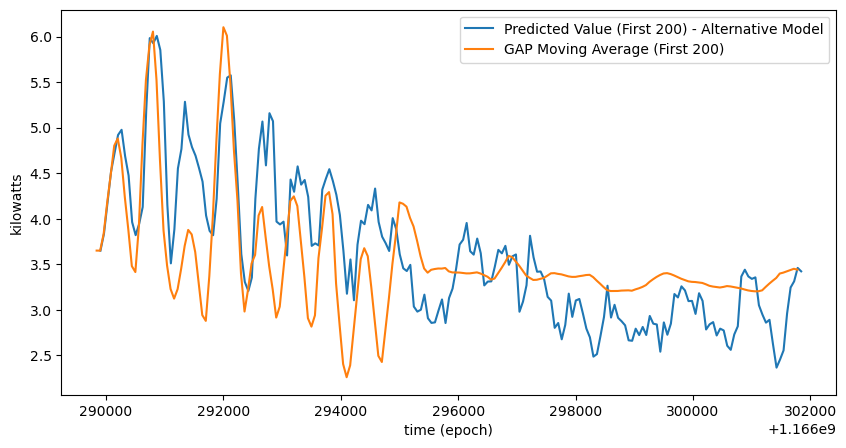

In [63]:
#Plot first 200 data points/predictions for alternative model
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value (First 200) - Alternative Model')
plt.plot(ts['unix'].iloc[:200], ys.iloc[:200, 0], label='GAP Moving Average (First 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()


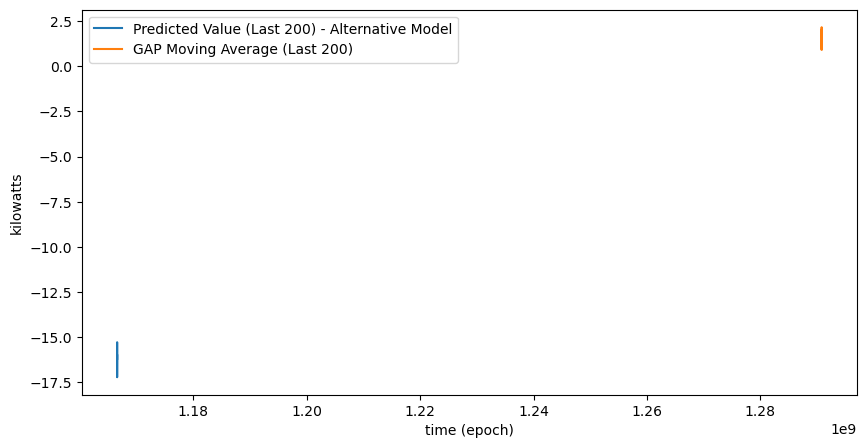

In [64]:
#Plot last 200 data points/predictions for alternative model
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value (Last 200) - Alternative Model')
plt.plot(ts['unix'].iloc[-200:], ys.iloc[-200:, 0], label='GAP Moving Average (Last 200)')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.show()

In [66]:
# Drop the first 4 NaN values and take the first n_s - 4 values for ys
ys_filtered = df['gap_moving_avg'].dropna().iloc[:n_s - 4]

# Take the first n_s - 4 values for predictions
yp_pred_aligned = yp_pred[:n_s - 4]

mse_alternative = mse(ys_filtered, yp_pred_aligned)
print("MSE for the alternative model is", mse_alternative)

MSE for the alternative model is 100.3596619982284


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The model does improve from the original results with mu = 0.9 (mse = 2141.13) to now while keeping mu = 0.9 (mse = 100.36). It demonstrates that a combination should be taken with mu = 1, a moving average, and potentially using voltage to gain better insights. This is a normal result and expected. Aside from including voltage, we could also include other features, such as 'Global_reactive_power' or 'Global_intensity'.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.